In [1]:
using Lale

In [2]:
using Random
using Statistics
using Test
using DataFrames: DataFrame, nrow

In [3]:
iris = getiris();
trx,tstx = holdout(nrow(iris),0.30)
training = iris[trx,:]
testing = iris[tstx,:];

In [4]:
clf_tr_X = training[:,1:4] |> DataFrame
clf_tr_y = training[:,5]   |> Vector
clf_tst_X = testing[:,1:4] |> DataFrame
clf_tst_y = testing[:,5] |> Vector;

## AutoML for classifier pipeline

This example uses Lale for combined algorithm selection and hyperparameter tuning
on a classifier pipeline.

The first step to create a pipeline is to instantiate the operators. `laleoperator` takes the name of the operator and an optional package argument. The default package is sklearn, which means by default it will try to instantiate operators from sklearn.

In [5]:
PCA = laleoperator("PCA")
RobustScaler = laleoperator("RobustScaler")
ConcatFeatures = laleoperator("ConcatFeatures", "lale")
LogisticRegression = laleoperator("LogisticRegression")
RandomForestClassifier = laleoperator("RandomForestClassifier");

The next step is to compose a pipeline using the operators and combinators defined in Lale. The table below summarizes the available pipeline combinators which can be used to define the pipeline directed acyclic graph:

| Symbol | Name | Description  | Sklearn feature |
| ------ | ---- | ------------ | --------------- |
| >>     | pipe | Feed to next | `make_pipeline` |
| &      | and  | Run both     | `make_union`, includes concat |
| &#x7c; | or   | Choose one   | (missing) |


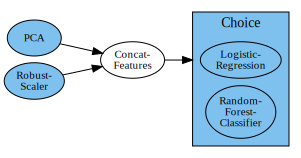

In [6]:
clf_planned = (PCA & RobustScaler) >> ConcatFeatures >> (LogisticRegression | RandomForestClassifier)
visualize(clf_planned)

`LalePipeOptimizer` takes the pipeline graph from above and we can provide a budget of the number of optimizer iterations along with other parameters such as cross validation number of folds. It internally uses hyperopt for performing the algorithm selection and hyperparameter tuning.
Lale follows sklearn API, so `fit` is for trainind and `predict` for obtaining the predictions.

100%|███████| 10/10 [00:06<00:00,  1.50trial/s, best loss: -0.9523809523809524]

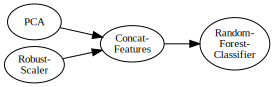

In [7]:
clf_hopt = LalePipeOptimizer(clf_planned, max_evals=10, cv=3)
clf_trained = fit(clf_hopt, clf_tr_X, clf_tr_y)
visualize(clf_trained)

In [8]:
clf_pred = predict(clf_trained, clf_tst_X)
clf_accu = score(:accuracy, clf_pred, clf_tst_y)

97.77777777777777

## AutoML for regressor pipeline

This example uses Lale for combined algorithm selection and hyperparameter tuning
on a regressor pipeline.

In [9]:
reg_tr_X = training[:,1:3] |> DataFrame
reg_tr_y = training[:,4]   |> Vector
reg_tst_X = testing[:,1:3] |> DataFrame
reg_tst_y = testing[:,4]   |> Vector;

In [10]:
PCA = laleoperator("PCA")
NoOp = laleoperator("NoOp", "lale")
LinearRegression = laleoperator("LinearRegression")
RandomForestRegressor = laleoperator("RandomForestRegressor");

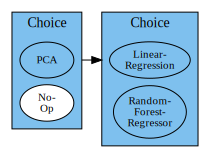

In [11]:
reg_planned = (PCA | NoOp) >> (LinearRegression | RandomForestRegressor);
visualize(reg_planned)


100%|███████| 10/10 [00:04<00:00,  2.27trial/s, best loss: -0.9384649494905651]

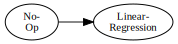

In [12]:
reg_hopt = LalePipeOptimizer(reg_planned, max_evals=10, cv=3)
reg_trained = fit(reg_hopt, reg_tr_X, reg_tr_y);
visualize(reg_trained)

In [13]:
reg_pred = predict(reg_trained, reg_tst_X)
reg_rmse = score(:rmse, reg_pred, reg_tst_y)

0.2251352674342222